<a href="https://colab.research.google.com/github/Akash1542/707-lecture-master/blob/main/AMLExercise1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive


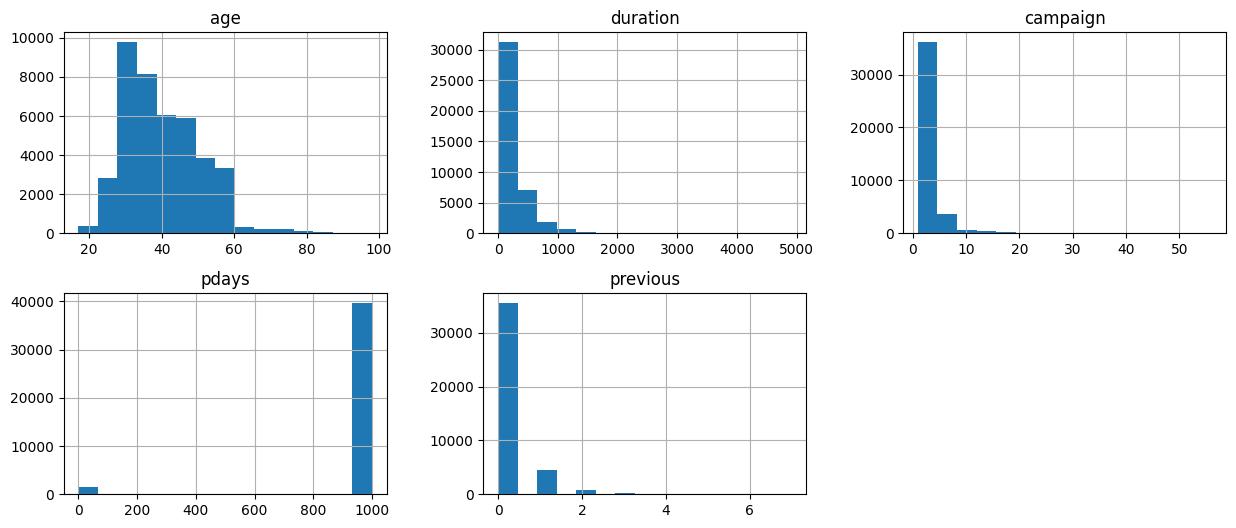

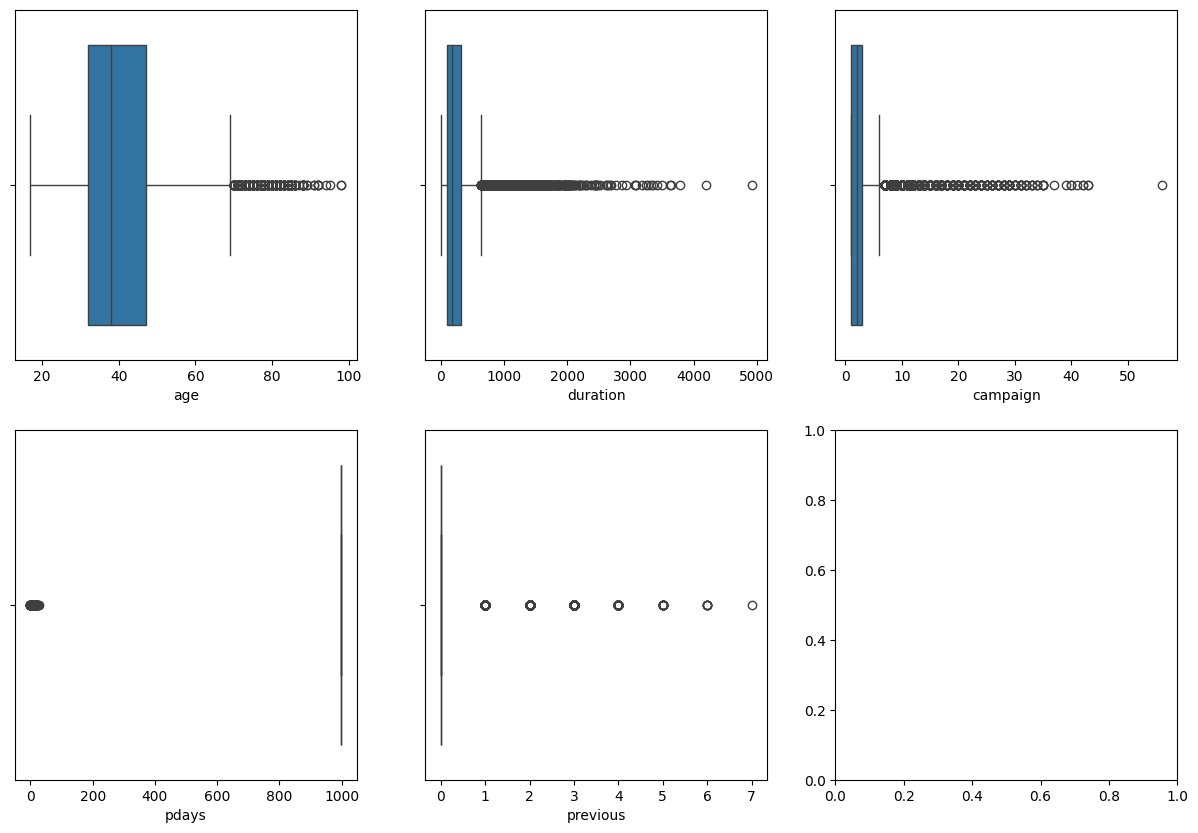

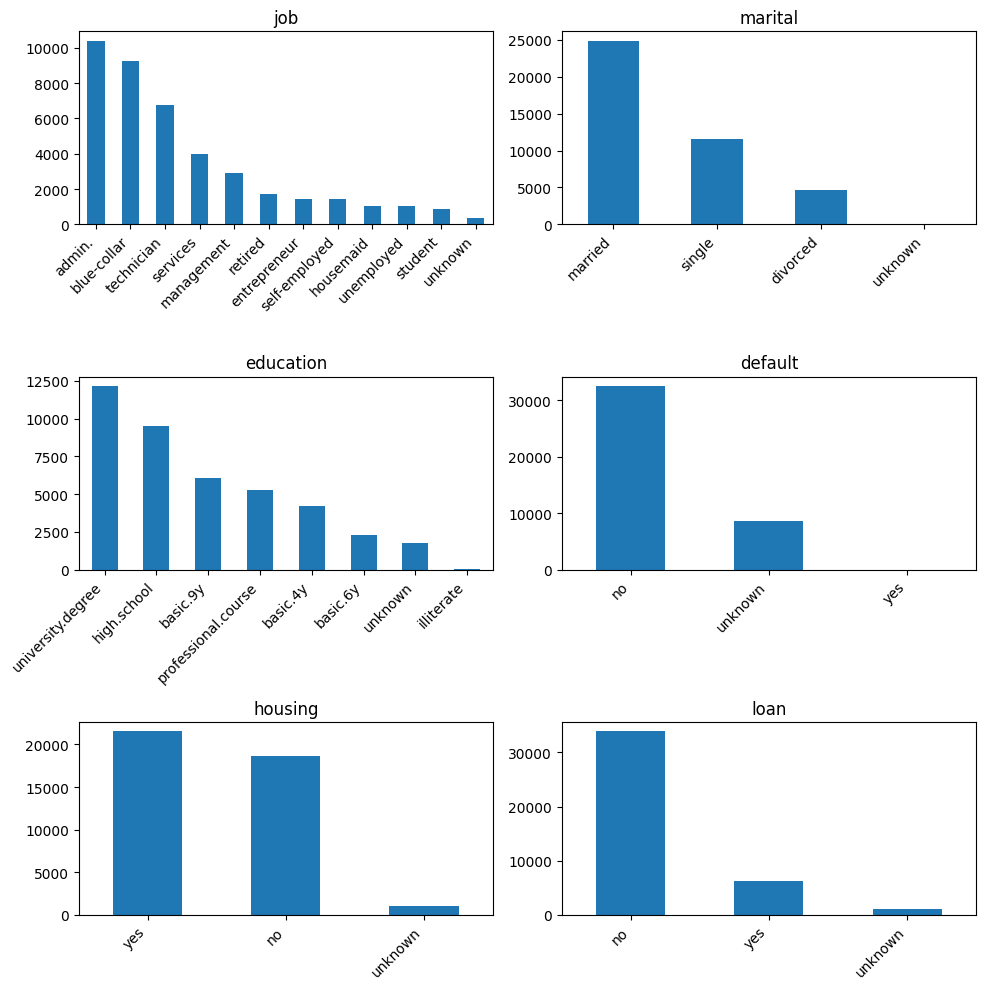

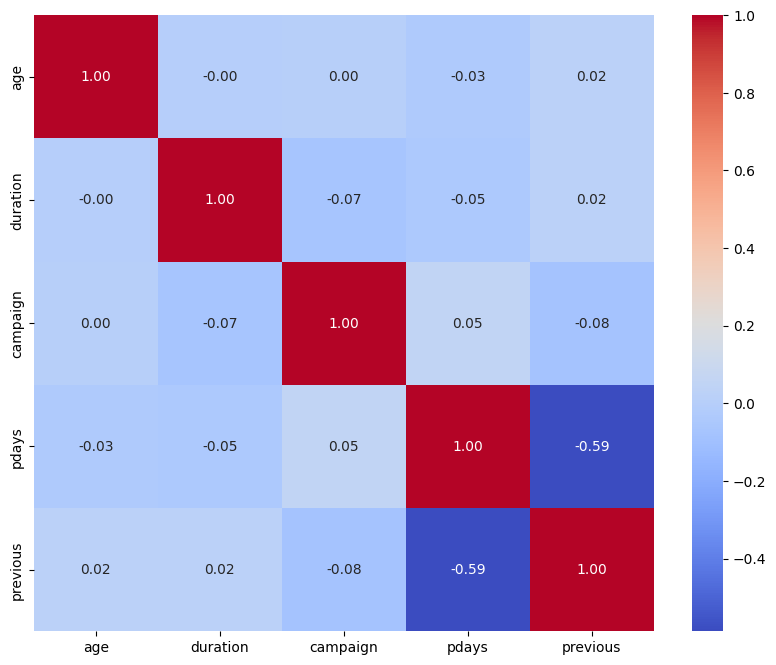

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.setrecursionlimit(10000)

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

file_path = '/content/bank-full.csv'
df = pd.read_csv(file_path, sep=';')
df.head(5)

# EDA

df.dtypes

# Descriptive statistics
df.describe()

# Histograms for numerical data
numerical_cols = ['age', 'duration', 'campaign', 'pdays', 'previous']
df[numerical_cols].hist(bins=15, figsize=(15, 6), layout=(2, 3))
plt.show()

# Boxplots for numerical data
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for var, subplot in zip(numerical_cols, ax.flatten()):
    sns.boxplot(x=df[var], ax=subplot)
plt.show()

# Bar charts for categorical data
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan']
fig, ax = plt.subplots(3, 2, figsize=(10, 10))

for var, subplot in zip(categorical_cols, ax.flatten()):
    df[var].value_counts().plot(kind='bar', ax=subplot, title=var)
    subplot.set_xticklabels(subplot.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

In [2]:
# Data preparation

# Check for standard null values
df.isnull().sum()

# Check unique values for each categorical column
for col in df.select_dtypes(include='object').columns:
    print(f'Unique values in {col}: {df[col].unique()}')
numpy_array = df.to_numpy()

# Replace non-standard missing values with NaN
df.replace(['NA', 'unknown'], pd.NA, inplace=True)

null_values_updated = df.isnull().sum()
print(null_values_updated)

df = df.drop(columns=['education', 'default'])

df['job'] = df['job'].fillna(df['job'].mode()[0])

df['marital'] = df['marital'].fillna(df['marital'].mode()[0])

df['housing'] = df['housing'].fillna(df['housing'].mode()[0])
df['loan'] = df['loan'].fillna(df['loan'].mode()[0])

null_values_after_updating = df.isnull().sum()
print(null_values_after_updating)

def is_numeric(df, column_name):
    return df[column_name].dtype in ['int64', 'float64']

# Identifying numerical features
numerical_features = [col for col in df.columns if is_numeric(df, col)]

# StandardScaler
scaler = StandardScaler()

# Scale the numerical features
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Check the scaled features
df.head()

categorical_cols = df.select_dtypes(include=['object']).columns
print(categorical_cols)

# Initializing OneHotEncoder
encoder = OneHotEncoder()

# Selecting categorical columns
categorical_data = df[categorical_cols]

# OneHotEncoder
encoded_data = encoder.fit_transform(df[categorical_cols])

new_columns = []
for i, col in enumerate(encoder.categories_):
    new_columns.extend([f"{categorical_cols[i]}_{category}" for category in col])

encoded_df = pd.DataFrame(encoded_data.toarray(), columns=new_columns)

df = pd.concat([df.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

df.drop(categorical_cols, axis=1, inplace=True)

df.dtypes

# checking for high correlation
corr_matrix = df.corr()

# Set the correlation threshold
threshold = 0.90

# Identified highly correlated features
corr_pairs = {}
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            corr_pairs[(corr_matrix.columns[i], corr_matrix.columns[j])] = corr_matrix.iloc[i, j]

print(corr_pairs)

# dropping highly corelated pairs
features_to_drop = set([feature_pair[0] for feature_pair in corr_pairs])

# Drop the features
df = df.drop(features_to_drop, axis=1)

# Checking for Variance

variance = df.var()
print(variance)

# removing based on low Variance

variance_threshold = 0.05
low_variance_features = [column for column, variance in df.var().items() if variance < variance_threshold]
print(low_variance_features)

df = df.drop(low_variance_features, axis=1)

# adding additional features

df['age_group'] = pd.cut(df['age'], bins=[20, 30, 40, 50, 60, 70, 80], labels=['20s', '30s', '40s', '50s', '60s', '70s'])

# For continuous variables we can create polynomial features which might help in capturing non-linear relationships.

df['age_squared'] = df['age'] ** 2
df['duration_squared'] = df['duration'] ** 2

df['campaign_squared'] = df['campaign'] ** 2
df['pdays_squared'] = df['pdays'] ** 2
df['previous_squared'] = df['previous'] ** 2

df['age_campaign_interaction'] = df['age'] * df['campaign']
df['age_pdays_interaction'] = df['age'] * df['pdays']

df.dtypes.count()

df = df.drop('age_group', axis=1)

Unique values in job: ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
Unique values in marital: ['married' 'single' 'divorced' 'unknown']
Unique values in education: ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
Unique values in default: ['no' 'unknown' 'yes']
Unique values in housing: ['no' 'yes' 'unknown']
Unique values in loan: ['no' 'yes' 'unknown']
Unique values in contact: ['telephone' 'cellular']
Unique values in month: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
Unique values in day_of_week: ['mon' 'tue' 'wed' 'thu' 'fri']
Unique values in poutcome: ['nonexistent' 'failure' 'success']
Unique values in y: ['no' 'yes']
age                  0
job                330
marital             80
education         1731
default           8597
housing            990
loan               990
contact          

In [3]:
# Model selection

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Split the data into features and target
X = df.drop("y_no", axis=1)
y = df["y_no"]

# Split the data into training and testing sets
X_train1, X_test1, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# StandardScaler
scaler = StandardScaler()

# Fit on training set
X_train = scaler.fit_transform(X_train1)

# Apply transform to both the training set and the testing set
X_test = scaler.transform(X_test1)

# DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Train model
dt_classifier.fit(X_train, y_train)

# SGDClassifier
sgd_classifier = SGDClassifier(random_state=42)

# Train model
sgd_classifier.fit(X_train, y_train)

# Predict and evaluate Decision Tree Classifier
dt_predictions = dt_classifier.predict(X_test)
print("Decision Tree Classifier Performance:")
print(classification_report(y_test, dt_predictions))

# Predict and evaluate SGD Classifier
sgd_predictions = sgd_classifier.predict(X_test)
print("SGD Classifier Performance:")
print(classification_report(y_test, sgd_predictions))

Decision Tree Classifier Performance:
              precision    recall  f1-score   support

         0.0       0.53      0.52      0.52       935
         1.0       0.94      0.94      0.94      7303

    accuracy                           0.89      8238
   macro avg       0.73      0.73      0.73      8238
weighted avg       0.89      0.89      0.89      8238

SGD Classifier Performance:
              precision    recall  f1-score   support

         0.0       0.65      0.39      0.49       935
         1.0       0.93      0.97      0.95      7303

    accuracy                           0.91      8238
   macro avg       0.79      0.68      0.72      8238
weighted avg       0.89      0.91      0.90      8238



In [4]:
# Evaluation

# MOdel Evaluation using Kfold

dt_scores = cross_val_score(dt_classifier, X_train, y_train, cv=5, scoring='accuracy')
print("Decision Tree Classifier Accuracy: %0.2f (+/- %0.2f)" % (dt_scores.mean(), dt_scores.std() * 2))

sgd_scores = cross_val_score(sgd_classifier, X_train, y_train, cv=5, scoring='accuracy')
print("SGD Classifier Accuracy: %0.2f (+/- %0.2f)" % (sgd_scores.mean(), sgd_scores.std() * 2))

Decision Tree Classifier Accuracy: 0.89 (+/- 0.01)
SGD Classifier Accuracy: 0.91 (+/- 0.01)


Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Parameters: {'alpha': 0.0001, 'eta0': 0.1, 'learning_rate': 'adaptive', 'max_iter': 1000}
Best Score: 0.9089226476098254
              precision    recall  f1-score   support

         0.0       0.67      0.39      0.49       935
         1.0       0.93      0.98      0.95      7303

    accuracy                           0.91      8238
   macro avg       0.80      0.68      0.72      8238
weighted avg       0.90      0.91      0.90      8238

Accuracy: 0.9084729303228939
SGD Classifier Accuracy: 0.91 (+/- 0.01)


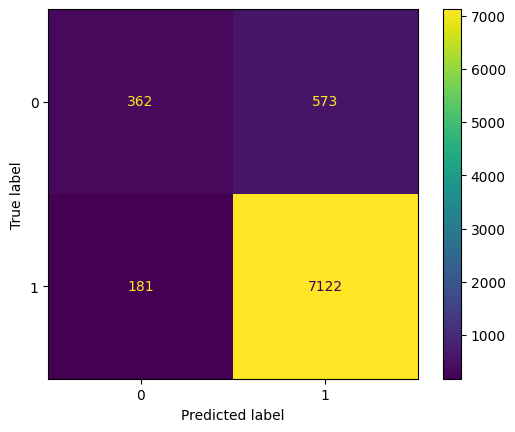

Accuracy: 0.91
Precision: 0.93
Recall: 0.98
F1 Score: 0.95


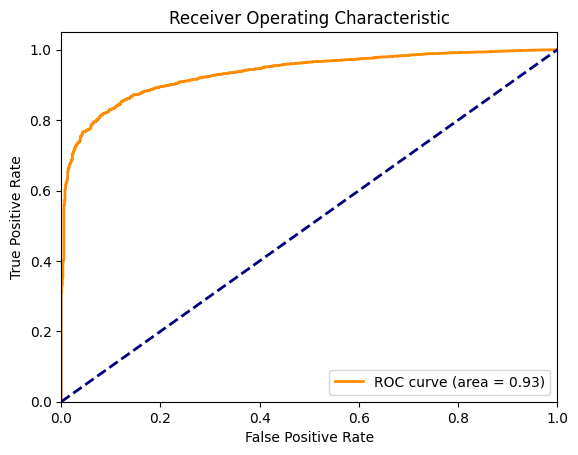

In [5]:
# Tuning

param_grid = {
    'alpha': [0.0001, 0.001, 0.01],  # Regularization parameter
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'eta0': [0.001, 0.01, 0.1],  # Initial learning rate (used when learning_rate is set to 'constant')
    'max_iter': [1000, 2000]  # Maximum number of passes over the data
}

grid_search = GridSearchCV(estimator=sgd_classifier, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

grid_search.fit(X_train, y_train)

best_parameters = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_parameters)
print("Best Score:", best_score)

best_sgd_classifier = SGDClassifier(alpha=0.0001, eta0=0.01, learning_rate='adaptive',
                                    max_iter=1000, random_state=42)

# Train the classifier
best_sgd_classifier.fit(X_train, y_train)

#Evaluate  performance on test set
y_pred = best_sgd_classifier.predict(X_test)

print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

sgd_scores = cross_val_score(best_sgd_classifier, X_train, y_train, cv=5, scoring='accuracy')
print("SGD Classifier Accuracy: %0.2f (+/- %0.2f)" % (sgd_scores.mean(), sgd_scores.std() * 2))

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score, auc

y_pred = best_sgd_classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

#decision scores
y_scores = best_sgd_classifier.decision_function(X_test)

from sklearn.metrics import roc_curve, auc

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# AUC
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [8]:
# Conclusion

"""Best Model Summary

**Model:** SGD Classifier with tuned hyperparameters.

**Performance:**

1. Area Under Curve: Nearly 1, indicating superior model performance
2. Attained around 91% accuracy.
3. High values indicate good performance across precision, recall, and F1-score criteria..

**Feature Engineering:** Create new features based on existing data.

**Ideas for Improvement**

**Try Various Models:** Conduct experiments using various models.

**Engineering Features:** Develop fresh features by utilising current data..
"""

'Best Model Summary\n\n**Model:** SGD Classifier with tuned hyperparameters.\n\n**Performance:**\n\n1. Area Under Curve: Nearly 1, indicating superior model performance\n2. Attained around 91% accuracy.\n3. High values indicate good performance across precision, recall, and F1-score criteria..\n\n**Feature Engineering:** Create new features based on existing data.\n\n**Ideas for Improvement**\n\n**Try Various Models:** Conduct experiments using various models.\n\n**Engineering Features:** Develop fresh features by utilising current data..\n'